# Práctica 2: Transformaciones geométricas

### Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time

import tkinter as tk
from tkinter import scrolledtext
import queue
import threading


### 1a. Desarrollar una aplicación que lleve a cabo transformaciones de la imagen en tiempo real a través de una interfaz basada en trackbars o equivalente.

- Hacer traslaciones. Es necesario indicar la magnitud de la traslación en X y en Y.
- Hacer rotaciones. Es necesario indicar el centro de giro y ángulo de giro.
- Hacer escalados uniformes y no uniformes. Es necesario indicar los factores de escala.

In [11]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- traslación: Indica como realizar una transformacion de traslación.\n")
            self.text_area.insert(tk.END, "- rotación: Indica como realizar una transformacion de rotación.\n")
            self.text_area.insert(tk.END, "- escalado_uniforme: Indica como realizar una transformacion de escalado uniforme.\n")
            self.text_area.insert(tk.END, "- escalado_no_uniforme: Indica como realizar una transformacion de escalado no uniforme.\n")
        elif user_input.lower() == "traslación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Traslación\n Para realizar una transformación de traslación primero deberá estar en el modo 'Traslacion' en la aplicación.\n El usario podrá emplear los trackbar 'X' e 'Y' para trasladar la imagen en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "rotación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Rotación\n Para realizar una transformación de rotación primero deberá estar en el modo 'Rotación' en la aplicación.\n El usario podrá emplear el trackbar 'Angulo' para rotar la imagen en un rango de 0 a 360 grados.\nOpcionalmente el usuario podrá determinar el centro de la rotación clickando en un punto de la imagen.\n")
        elif user_input.lower() == "escalado_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado Uniforme\n Para realizar una transformación de escalado uniforme primero deberá estar en el modo 'Escalado Uniforme' en la aplicación.\n El usario podrá emplear el trackbar 'Escala' para escalar la imagen.\n")
        elif user_input.lower() == "escalado_no_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado No Uniforme\n Para realizar una transformación de escalado no uniforme primero deberá estar en el modo 'Escalado No Uniforme' en la aplicación.\n El usario podrá emplear los trackbars 'Escala_X' y 'Escala_Y' para escalar la imagen en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [16]:
def opencv_app(close_queue):

    # Load the image
    img = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError("La imagen no se encontró en la ruta especificada.")

    def nothing(x):
        pass

    height, width = img.shape[:2]
    size = (width, height)

    # Create a window
    cv.namedWindow('image')

    # Create trackbars
    cv.createTrackbar('X', 'image', 0, width, nothing)
    cv.createTrackbar('Y', 'image', 0, height, nothing)
    cv.createTrackbar('Angulo', 'image', 0, 360, nothing)
    cv.createTrackbar('Escala', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala X', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala Y', 'image', 50, 100, nothing)

    mode = 'Traslación'
    center = (width // 2, height // 2)
    show_text = False
    text_display_time = 2
    text_start_time = 0

    # Mouse callback to get center
    def get_center(event, x, y, flags, param):
        nonlocal center, show_text, text_start_time
        if event == cv.EVENT_LBUTTONDOWN:
            center = (x, y)
        elif event == cv.EVENT_LBUTTONUP:
            pass  # Optionally, handle if needed

    cv.setMouseCallback('image', get_center)
    cv.imshow('image', img)

    while True:
        key = cv.waitKey(1) & 0xFF

        if key == ord('m'):
            # Cycle through modes
            if mode == 'Traslación':
                mode = 'Rotación'
            elif mode == 'Rotación':
                mode = 'Escalado Uniforme'
            elif mode == 'Escalado Uniforme':
                mode = 'Escalado No Uniforme'
            elif mode == 'Escalado No Uniforme':
                mode = 'Traslación'  

            show_text = True
            text_start_time = time.time()

        img_display = img.copy()

        # Get trackbar positions
        tx = cv.getTrackbarPos('X', 'image')
        ty = cv.getTrackbarPos('Y', 'image')
        angle = cv.getTrackbarPos('Angulo', 'image')
        escala = cv.getTrackbarPos('Escala', 'image')
        escala_x = cv.getTrackbarPos('Escala X', 'image')
        escala_y = cv.getTrackbarPos('Escala Y', 'image')

        # Apply transformations based on mode
        if mode == 'Traslación':
            T = np.float32([[1, 0, tx], [0, 1, ty]])
            img_display = cv.warpAffine(img_display, T, size)
            texto = 'Modo: Traslacion'

        elif mode == 'Rotación':
            R = cv.getRotationMatrix2D(center, angle, 1)
            img_display = cv.warpAffine(img_display, R, size)
            texto = 'Modo: Rotacion'

        elif mode == 'Escalado Uniforme':
            scale_factor = escala / 50.0  
            S = cv.getRotationMatrix2D(center, 0, scale_factor)
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado Uniforme'

        elif mode == 'Escalado No Uniforme':
            scale_x_factor = escala_x / 50.0  
            scale_y_factor = escala_y / 50.0
            S = np.float32([
                [scale_x_factor, 0, (1 - scale_x_factor) * center[0]],
                [0, scale_y_factor, (1 - scale_y_factor) * center[1]]
            ])
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado No Uniforme'

        # Display mode text
        current_time = time.time()
        if show_text:
            elapsed_time = current_time - text_start_time
            if elapsed_time < text_display_time:
                cv.rectangle(img_display, (0, 0), (500, 30), (0, 0, 0), cv.FILLED)
                cv.putText(img_display, texto, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            else:
                show_text = False

        cv.imshow('image', img_display)

        if key == 27:  # ESC key
            break

        # Check if a close request was received
        if not close_queue.empty():
            break

    cv.destroyAllWindows()
    # Send a message to close the shell
    close_queue.put("close_shell")


In [17]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

### 1b. Dada una imagen trazar una ventana de proyección y proyectar la imagen.

In [13]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- proyección: Indica como realizar una proyección.\n")
        elif user_input.lower() == "proyección":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Proyección:\nPara realizar una proyección el usuario deberá clickar en la imagen para determinar las esquinas de la ventana de proyección, en el siguiente orden:\n")
            self.text_area.insert(tk.END, "Esquina superior izquierda, esquina inferior izquierda, esquina inferior derecha y esquina superior derecha.\n")
            self.text_area.insert(tk.END, "Una vez marcado los 4 puntos de la ventana, el usuario podrá pulsar la tecla 'd' para realizar la proyección en dicha ventana.")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- d: Realiza la proyección de la imagen en la ventana creada por el usuario.\n- r: Elimina el último punto señalado para la ventana.\n- q: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [14]:
def opencv_app(close_queue):
    img_orig = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    img = img_orig.copy()
    points = []
    actions = []
    w,h = img.shape[1], img.shape[0]
    size = (w,h)
    pts1 = np.float32([[0,0], [0,h], [w,h], [w,0]])

    def save_point(event, x, y, flags, param):
        global points
        if event == cv.EVENT_LBUTTONDOWN:
            points.append([x, y])
        elif event == cv.EVENT_LBUTTONUP:
            cv.circle(img, (x, y), 5, (0, 0, 255), -1)
            actions.append(img.copy())
            cv.imshow('image', img)

    cv.namedWindow('image')
    cv.setMouseCallback('image', save_point)
    cv.imshow('image', img)

    while True:
        key = cv.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        if len(points) == 4:
            pts2 = np.float32([points[0], points[1], points[2], points[3]])
            
            Tp = cv.getPerspectiveTransform(pts1, pts2)
            img_p = cv.warpPerspective(img_orig, Tp, size)

            pts = pts2.astype(np.int32)
            pts = pts.reshape((-1,1,2))
            cv.polylines(img, [pts], True, (0, 255, 0), 2)
            cv.imshow('image', img_p)
        elif key == ord('d'):
            points = []
            actions = []
            cv.imshow('image', img)
        elif key == ord('r') and len(actions) != 0:
            points.pop()
            actions.pop()
            img = actions[-1].copy()
            cv.imshow('image', img)
            
    # Check if a close request was received
        if not close_queue.empty():
            break

    cv.destroyAllWindows()
    # Send a message to close the shell
    close_queue.put("close_shell")

In [15]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

### 1c. Desarrollar una aplicación que lleve a cabo distorsiones de la lente. Para ello los coeficientes de distorsión deben gobernarse a través de una interfaz

In [5]:
def apply_distortion(image, k1, k2):
    h, w = image.shape[:2]
    distCoeff = np.zeros((4,1), np.float64)
    distCoeff[0,0] = k1
    distCoeff[1,0] = k2

    cam = np.eye(3, dtype=np.float32)
    cam[0,2] = w/2.0 
    cam[1,2] = h/2.0
    cam[0,0] = 10.
    cam[1,1] = 10.

    distorted_img = cv.undistort(image, cam, distCoeff)

    return distorted_img

In [6]:
def update_image(val):
    global image
    k1 = (cv.getTrackbarPos('K1', 'DistLente') - 100) / 100000.0
    k2 = (cv.getTrackbarPos('K2', 'DistLente') - 100) / 100000.0

    if k1 > 0 and k2 > 0:
        distorted_img = apply_distortion(image, k1, k2)
        return distorted_img
    elif k1 < 0 and k2 < 0:
        distorted_img = apply_distortion(image, k1, k2)
        return distorted_img
    else:
        return image

def nothing(x):
    pass

In [7]:
img = cv.imread('images/img_cuadro.jpg', cv.IMREAD_COLOR)
image = img.copy()

cv.namedWindow('DistLente')
cv.createTrackbar('K1', 'DistLente', 100, 200, nothing)
cv.createTrackbar('K2', 'DistLente', 100, 200, nothing)

update_image(0)

while True:
    key = cv.waitKey(1) & 0xFF
    
    if key == 27:
        break

    disorted_img = update_image(image)
    cv.imshow('DistLente', disorted_img)

cv.destroyAllWindows()

## Optativos

#### - Marcar el punto de giro con el ratón.

In [24]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- traslación: Indica como realizar una transformacion de traslación.\n")
            self.text_area.insert(tk.END, "- rotación: Indica como realizar una transformacion de rotación.\n")
            self.text_area.insert(tk.END, "- escalado_uniforme: Indica como realizar una transformacion de escalado uniforme.\n")
            self.text_area.insert(tk.END, "- escalado_no_uniforme: Indica como realizar una transformacion de escalado no uniforme.\n")
        elif user_input.lower() == "traslación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Traslación\n Para realizar una transformación de traslación primero deberá estar en el modo 'Traslacion' en la aplicación.\n El usario podrá emplear los trackbar 'X' e 'Y' para trasladar la imagen en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "rotación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Rotación\n Para realizar una transformación de rotación primero deberá estar en el modo 'Rotación' en la aplicación.\n El usario podrá emplear el trackbar 'Angulo' para rotar la imagen en un rango de 0 a 360 grados.\nOpcionalmente el usuario podrá determinar el centro de la rotación clickando en un punto de la imagen.\n")
        elif user_input.lower() == "escalado_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado Uniforme\n Para realizar una transformación de escalado uniforme primero deberá estar en el modo 'Escalado Uniforme' en la aplicación.\n El usario podrá emplear el trackbar 'Escala' para escalar la imagen.\n")
        elif user_input.lower() == "escalado_no_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado No Uniforme\n Para realizar una transformación de escalado no uniforme primero deberá estar en el modo 'Escalado No Uniforme' en la aplicación.\n El usario podrá emplear los trackbars 'Escala_X' y 'Escala_Y' para escalar la imagen en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [25]:
def opencv_app(close_queue):

    # Load the image
    img = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError("La imagen no se encontró en la ruta especificada.")

    def nothing(x):
        pass

    height, width = img.shape[:2]
    size = (width, height)

    # Create a window
    cv.namedWindow('image')

    # Create trackbars
    cv.createTrackbar('X', 'image', 0, width, nothing)
    cv.createTrackbar('Y', 'image', 0, height, nothing)
    cv.createTrackbar('Angulo', 'image', 0, 360, nothing)
    cv.createTrackbar('Escala', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala X', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala Y', 'image', 50, 100, nothing)

    mode = 'Traslación'
    center = (width // 2, height // 2)
    show_text = False
    text_display_time = 2
    text_start_time = 0

    # Mouse callback to get center
    def get_center(event, x, y, flags, param):
        nonlocal center, show_text, text_start_time
        if event == cv.EVENT_LBUTTONDOWN:
            center = (x, y)
        elif event == cv.EVENT_LBUTTONUP:
            cv.circle(img, (x, y), 5, (0, 0, 255), -1)

    cv.setMouseCallback('image', get_center)
    cv.imshow('image', img)

    while True:
        key = cv.waitKey(1) & 0xFF

        if key == ord('m'):
            # Cycle through modes
            if mode == 'Traslación':
                mode = 'Rotación'
            elif mode == 'Rotación':
                mode = 'Escalado Uniforme'
            elif mode == 'Escalado Uniforme':
                mode = 'Escalado No Uniforme'
            elif mode == 'Escalado No Uniforme':
                mode = 'Traslación'  

            show_text = True
            text_start_time = time.time()

        img_display = img.copy()

        # Get trackbar positions
        tx = cv.getTrackbarPos('X', 'image')
        ty = cv.getTrackbarPos('Y', 'image')
        angle = cv.getTrackbarPos('Angulo', 'image')
        escala = cv.getTrackbarPos('Escala', 'image')
        escala_x = cv.getTrackbarPos('Escala X', 'image')
        escala_y = cv.getTrackbarPos('Escala Y', 'image')

        # Apply transformations based on mode
        if mode == 'Traslación':
            T = np.float32([[1, 0, tx], [0, 1, ty]])
            img_display = cv.warpAffine(img_display, T, size)
            texto = 'Modo: Traslacion'

        elif mode == 'Rotación':
            R = cv.getRotationMatrix2D(center, angle, 1)
            img_display = cv.warpAffine(img_display, R, size)
            texto = 'Modo: Rotacion'

        elif mode == 'Escalado Uniforme':
            scale_factor = escala / 50.0  
            S = cv.getRotationMatrix2D(center, 0, scale_factor)
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado Uniforme'

        elif mode == 'Escalado No Uniforme':
            scale_x_factor = escala_x / 50.0  
            scale_y_factor = escala_y / 50.0
            S = np.float32([
                [scale_x_factor, 0, (1 - scale_x_factor) * center[0]],
                [0, scale_y_factor, (1 - scale_y_factor) * center[1]]
            ])
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado No Uniforme'

        # Display mode text
        current_time = time.time()
        if show_text:
            elapsed_time = current_time - text_start_time
            if elapsed_time < text_display_time:
                cv.rectangle(img_display, (0, 0), (500, 30), (0, 0, 0), cv.FILLED)
                cv.putText(img_display, texto, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            else:
                show_text = False

        cv.imshow('image', img_display)

        if key == 27:  # ESC key
            break

        # Check if a close request was received
        if not close_queue.empty():
            break

    cv.destroyAllWindows()
    # Send a message to close the shell
    close_queue.put("close_shell")


In [26]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

#### - Trasladar la imagen arrastrándolo con el ratón y visualizarlo en tiempo real

In [27]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- traslación: Indica como realizar una transformacion de traslación.\n")
            self.text_area.insert(tk.END, "- rotación: Indica como realizar una transformacion de rotación.\n")
            self.text_area.insert(tk.END, "- escalado_uniforme: Indica como realizar una transformacion de escalado uniforme.\n")
            self.text_area.insert(tk.END, "- escalado_no_uniforme: Indica como realizar una transformacion de escalado no uniforme.\n")
        elif user_input.lower() == "traslación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Traslación\n Para realizar una transformación de traslación primero deberá estar en el modo 'Traslacion' en la aplicación.\n El usario podrá trasladar la imagen clickando sobre esta y moviendola con el cursor mientras sostiene apretado el botón.\n")
        elif user_input.lower() == "rotación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Rotación\n Para realizar una transformación de rotación primero deberá estar en el modo 'Rotación' en la aplicación.\n El usario podrá emplear el trackbar 'Angulo' para rotar la imagen en un rango de 0 a 360 grados.\nOpcionalmente el usuario podrá determinar el centro de la rotación clickando en un punto de la imagen.\n")
        elif user_input.lower() == "escalado_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado Uniforme\n Para realizar una transformación de escalado uniforme primero deberá estar en el modo 'Escalado Uniforme' en la aplicación.\n El usario podrá emplear el trackbar 'Escala' para escalar la imagen.\n")
        elif user_input.lower() == "escalado_no_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado No Uniforme\n Para realizar una transformación de escalado no uniforme primero deberá estar en el modo 'Escalado No Uniforme' en la aplicación.\n El usario podrá emplear los trackbars 'Escala_X' y 'Escala_Y' para escalar la imagen en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [28]:
def opencv_app(close_queue):
    img = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError("La imagen no se encontró en la ruta especificada.")

    def nothing(x):
        pass

    global center, show_text, text_start_time, dragging, prev_mouse_pos

    height, width = img.shape[:2]
    size = (width, height)

    cv.namedWindow('image')

    cv.createTrackbar('Angulo', 'image', 0, 360, nothing)
    cv.createTrackbar('Escala', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala X', 'image', 50, 100, nothing)
    cv.createTrackbar('Escala Y', 'image', 50, 100, nothing)

    mode = 'Traslación'
    
    center = (width // 2, height // 2)
    dragging = False
    prev_mouse_pos = center

    show_text = False
    text_display_time = 2  # segundos
    text_start_time = 0

    def get_center(event, x, y, flags, param):
        global center, dragging, prev_mouse_pos

        if event == cv.EVENT_LBUTTONDOWN:
            if mode == 'Traslación':
                dragging = True
                prev_mouse_pos = (x, y)

        elif event == cv.EVENT_MOUSEMOVE and dragging:
            dx = x - prev_mouse_pos[0]
            dy = y - prev_mouse_pos[1]
            center = (center[0] + dx, center[1] + dy)
            prev_mouse_pos = (x, y)

        elif event == cv.EVENT_LBUTTONUP:
            dragging = False

    cv.setMouseCallback('image', get_center)

    cv.imshow('image', img)

    while True:
        key = cv.waitKey(1) & 0xFF

        if key == ord('m'):
            if mode == 'Traslación':
                mode = 'Rotación'
            elif mode == 'Rotación':
                mode = 'Escalado Uniforme'
            elif mode == 'Escalado Uniforme':
                mode = 'Escalado No Uniforme'
            elif mode == 'Escalado No Uniforme':
                mode = 'Traslación'  

            show_text = True
            text_start_time = time.time()

        img_display = img.copy()

        angle = cv.getTrackbarPos('Angulo', 'image')
        escala = cv.getTrackbarPos('Escala', 'image')
        escala_x = cv.getTrackbarPos('Escala X', 'image')
        escala_y = cv.getTrackbarPos('Escala Y', 'image')

        if mode == 'Traslación':
            T = np.float32([[1, 0, center[0] - width // 2],
                            [0, 1, center[1] - height // 2]])
            img_display = cv.warpAffine(img_display, T, size)
            texto = 'Modo: Traslacion'

        elif mode == 'Rotación':
            R = cv.getRotationMatrix2D(center, angle, 1)
            img_display = cv.warpAffine(img_display, R, size)
            texto = 'Modo: Rotacion'

        elif mode == 'Escalado Uniforme':
            scale_factor = escala / 50.0
            S = cv.getRotationMatrix2D(center, 0, scale_factor)
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado Uniforme'

        elif mode == 'Escalado No Uniforme':
            scale_x_factor = escala_x / 50.0
            scale_y_factor = escala_y / 50.0
            S = np.float32([[scale_x_factor, 0, (1 - scale_x_factor) * center[0]],
                            [0, scale_y_factor, (1 - scale_y_factor) * center[1]]])
            img_display = cv.warpAffine(img_display, S, size)
            texto = 'Modo: Escalado No Uniforme'

        current_time = time.time()
        if show_text:
            elapsed_time = current_time - text_start_time
            if elapsed_time < text_display_time:
                cv.rectangle(img_display, (0, 0), (500, 30), (0, 0, 0), cv.FILLED)
                cv.putText(img_display, texto, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            else:
                show_text = False

        cv.imshow('image', img_display)

        if key == 27:
            break

        if not close_queue.empty():
            break

    cv.destroyAllWindows()
    close_queue.put("close_shell")

In [29]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

#### - Hacer la parte obligatoria sobre vídeo en lugar de sobre imagen.

#####  1.a

In [9]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- traslación: Indica como realizar una transformacion de traslación.\n")
            self.text_area.insert(tk.END, "- rotación: Indica como realizar una transformacion de rotación.\n")
            self.text_area.insert(tk.END, "- escalado_uniforme: Indica como realizar una transformacion de escalado uniforme.\n")
            self.text_area.insert(tk.END, "- escalado_no_uniforme: Indica como realizar una transformacion de escalado no uniforme.\n")
        elif user_input.lower() == "traslación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Traslación\n Para realizar una transformación de traslación primero deberá estar en el modo 'Traslacion' en la aplicación.\n El usario podrá emplear los trackbar 'X' e 'Y' para trasladar el video en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "rotación":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Rotación\n Para realizar una transformación de rotación primero deberá estar en el modo 'Rotación' en la aplicación.\n El usario podrá emplear el trackbar 'Angulo' para rotar el video en un rango de 0 a 360 grados.\nOpcionalmente el usuario podrá determinar el centro de la rotación clickando en un punto del video.\n")
        elif user_input.lower() == "escalado_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado Uniforme\n Para realizar una transformación de escalado uniforme primero deberá estar en el modo 'Escalado Uniforme' en la aplicación.\n El usario podrá emplear el trackbar 'Escala' para escalar el video.\n")
        elif user_input.lower() == "escalado_no_uniforme":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Escalado No Uniforme\n Para realizar una transformación de escalado no uniforme primero deberá estar en el modo 'Escalado No Uniforme' en la aplicación.\n El usario podrá emplear los trackbars 'Escala_X' y 'Escala_Y' para escalar el video en los ejes 'x' e 'y'.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [10]:
def opencv_app(close_queue):

    video = cv.VideoCapture(0)

    _, frame = video.read()


    def nothing(x):
        pass

    size = (frame.shape[1], frame.shape[0])
    width, height = size


    cv.namedWindow('video')

    cv.createTrackbar('X', 'video', 0, width, nothing)
    cv.createTrackbar('Y', 'video', 0, height, nothing)


    cv.createTrackbar('Angulo', 'video', 0, 360, nothing)


    cv.createTrackbar('Escala', 'video', 50, 100, nothing)
    cv.createTrackbar('Escala X', 'video', 50, 100, nothing)
    cv.createTrackbar('Escala Y', 'video', 50, 100, nothing)

    mode = 'Traslación'

    center = (width // 2, height // 2)


    show_text = False
    text_display_time = 2  # segundos
    text_start_time = 0

    def get_center(event, x, y, flags, param):
        global center, show_text, text_start_time
        if event == cv.EVENT_LBUTTONDOWN:
            center = (x, y)
        elif event == cv.EVENT_LBUTTONUP:
            return center
            


    cv.setMouseCallback('video', get_center)

    cv.imshow('video', frame)

    while True:

        _, frame = video.read()

        key = cv.waitKey(1) & 0xFF

        if key == ord('m'):
            if mode == 'Traslación':
                mode = 'Rotación'
            elif mode == 'Rotación':
                mode = 'Escalado Uniforme'
            elif mode == 'Escalado Uniforme':
                mode = 'Escalado No Uniforme'
            elif mode == 'Escalado No Uniforme':
                mode = 'Traslación'  

            show_text = True
            text_start_time = time.time()

    

        tx = cv.getTrackbarPos('X', 'video')
        ty = cv.getTrackbarPos('Y', 'video')
        angle = cv.getTrackbarPos('Angulo', 'video')
        escala = cv.getTrackbarPos('Escala', 'video')
        escala_x = cv.getTrackbarPos('Escala X', 'video')
        escala_y = cv.getTrackbarPos('Escala Y', 'video')

        if mode == 'Traslación':

            T = np.float32([[1, 0, tx], [0, 1, ty]])
            frame = cv.warpAffine(frame, T, size)
            texto = f'Modo: Traslacion'

        elif mode == 'Rotación':

            R = cv.getRotationMatrix2D(center, angle, 1)
            frame = cv.warpAffine(frame, R, size)
            texto = f'Modo: Rotacion'

        elif mode == 'Escalado Uniforme':

            scale_factor = escala / 50.0  

            S = cv.getRotationMatrix2D(center, 0, scale_factor)
            frame = cv.warpAffine(frame, S, size)
            texto = f'Modo: Escalado Uniforme'

        elif mode == 'Escalado No Uniforme':

            scale_x_factor = escala_x / 50.0  
            scale_y_factor = escala_y / 50.0

            S = np.float32([[scale_x_factor, 0, (1 - scale_x_factor) * center[0]],
                            [0, scale_y_factor, (1 - scale_y_factor) * center[1]]])
            frame = cv.warpAffine(frame, S, size)
            texto = f'Modo: Escalado No Uniforme'


        current_time = time.time()
        if show_text:
            elapsed_time = current_time - text_start_time
            if elapsed_time < text_display_time:

                cv.rectangle(frame, (0, 0), (500, 30), (0, 0, 0), cv.FILLED)

                cv.putText(frame, texto, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            else:

                show_text = False
        
        cv.imshow('video', frame)

        if key == 27:
            break
        
        if not close_queue.empty():
            break

    video.release()
    cv.destroyAllWindows()
    close_queue.put("close_shell")


In [11]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

##### 1.b

In [12]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- proyección: Indica como realizar una proyección.\n")
        elif user_input.lower() == "proyección":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Proyección:\nPara realizar una proyección el usuario deberá clickar en el video para determinar las esquinas de la ventana de proyección, en el siguiente orden:\n")
            self.text_area.insert(tk.END, "Esquina superior izquierda, esquina inferior izquierda, esquina inferior derecha y esquina superior derecha.\n")
            self.text_area.insert(tk.END, "Una vez marcado los 4 puntos de la ventana, el usuario podrá pulsar la tecla 'd' para realizar la proyección en dicha ventana.")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia de transformación.\n- d: Realiza la proyección del video en la ventana creada por el usuario.\n- r: Elimina el último punto señalado para la ventana.\n- q: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [15]:
def opencv_app(close_queue):
    video = cv.VideoCapture(0)

    if not video.isOpened():
        raise Exception("Could not open video device")

    _, frame = video.read()

    size = (frame.shape[1], frame.shape[0])
    w, h = size

    global points, actions
    points = []
    actions = []

    pts1 = np.float32([[0, 0], [0, h], [w, h], [w, 0]])

    def save_point(event, x, y, flags, param):
        global points, actions
        if event == cv.EVENT_LBUTTONDOWN:
            points.append([x, y])
            cv.circle(frame, (x, y), 5, (0, 0, 255), -1)
            actions.append(frame.copy())
            cv.imshow('video', frame)

    cv.namedWindow('video')
    cv.setMouseCallback('video', save_point)

    while True:
        _, frame = video.read()

        key = cv.waitKey(1) & 0xFF

        if key == ord('q'):
            break

        if len(points) == 4:
            pts2 = np.float32([points[0], points[1], points[2], points[3]])
            
            Tp = cv.getPerspectiveTransform(pts1, pts2)
            frame = cv.warpPerspective(frame, Tp, size)

            pts = pts2.astype(np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv.polylines(frame, [pts], True, (0, 255, 0), 2)
        
        elif key == ord('d'):
            points = []
            actions = []

        cv.imshow('video', frame)

        if not close_queue.empty():
            break

    video.release()
    cv.destroyAllWindows()
    close_queue.put("close_shell")

In [16]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

##### 1.c

In [ ]:
def apply_distortion(frame, k1, k2):
    size = (frame.shape[1], frame.shape[0])
    w, h = size
    distCoeff = np.zeros((4,1), np.float64)
    distCoeff[0,0] = k1
    distCoeff[1,0] = k2

    cam = np.eye(3, dtype=np.float32)
    cam[0,2] = w/2.0 
    cam[1,2] = h/2.0
    cam[0,0] = 10.
    cam[1,1] = 10.

    frame = cv.undistort(frame, cam, distCoeff)

    return frame

In [ ]:
def update_image(val):
    global frame
    k1 = (cv.getTrackbarPos('K1', 'DistLente') - 100) / 100000.0
    k2 = (cv.getTrackbarPos('K2', 'DistLente') - 100) / 100000.0

    if k1 > 0 and k2 > 0:
        frame = apply_distortion(frame, k1, k2)
        return frame
    elif k1 < 0 and k2 < 0:
        frame = apply_distortion(frame, k1, k2)
        return frame
    else:
        return frame

def nothing(x):
    pass

In [ ]:
video = cv.VideoCapture(0)

_, frame = video.read()

size = (frame.shape[1], frame.shape[0])
w, h = size

cv.namedWindow('DistLente')
cv.createTrackbar('K1', 'DistLente', 100, 200, nothing)
cv.createTrackbar('K2', 'DistLente', 100, 200, nothing)

update_image(0)

cv.imshow('DistLente', frame)
while True:

    _, frame = video.read()

    key = cv.waitKey(1) & 0xFF
    
    if key == 27:
        break
    if key == ord('d'):
        name = f'./foto_{time.strftime("%Y%m%d_%H%M%S")}.png'
        cv.imwrite(name, frame_b)
    

    frame_b = update_image(frame)
    cv.imshow('DistLente', frame_b)

video.release()
cv.destroyAllWindows()


#### - Dada una imagen seleccionar tres puntos de la imagen original y tres puntos en  una imagen destino y realizar la transformación afín.

In [30]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
            self.text_area.insert(tk.END, "- afín: Indica como realizar transformación afín.\n")
        elif user_input.lower() == "afín":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Transformación Afín:\nPara realizar una transformación afín el usuario deberá clickar en la imagen para determinar los puntos de la imagen original, y posteriormente los tres puntos destino.\n")
            self.text_area.insert(tk.END, "Una vez hecho esto, se realizará la transformación afín automáticamente.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- d: Elimina todos los puntos marcados.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [31]:
def opencv_app(close_queue):
    img = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError("La imagen no se encontró en la ruta especificada.")

    def nothing(x):
        pass

    height, width = img.shape[:2]
    size = (width, height)

    points_orig = []
    points_dest = []

    def select_points(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            if len(points_orig) < 3:
                points_orig.append([x, y])
                cv.circle(img, (x, y), 5, (0, 0, 255), -1)
            elif len(points_orig) == 3 and len(points_dest) < 3:
                points_dest.append([x, y])
                cv.circle(img, (x, y), 5, (255, 0, 0), -1)

    def apply_affine_transform(img, points_orig, points_dest):
        pts1 = np.float32(points_orig)
        pts2 = np.float32(points_dest)

        M = cv.getAffineTransform(pts1, pts2)
        img_transformed = cv.warpAffine(img, M, size)

        return img_transformed

    cv.namedWindow('image')
    cv.setMouseCallback('image', select_points)
    img_orig = img.copy()
    img_copy = img.copy()

    while True:
        cv.imshow('image', img)
        key = cv.waitKey(1) & 0xFF

        if key == 27:  # ESC key
            break

        if len(points_orig) == 3 and len(points_dest) == 3:
            img = apply_affine_transform(img_copy, points_orig, points_dest)
            img_copy = img.copy()
            points_orig = []
            points_dest = []

        if key == ord('d'):
            img = img_orig.copy()
            img_copy = img_orig.copy()
            points_orig = []
            points_dest = []

        # Check if a close request was received
        if not close_queue.empty():
            close_request = close_queue.get_nowait()
            if close_request == "close":
                break

    cv.destroyAllWindows()
    # Send a message to close the shell
    close_queue.put("close_shell")

In [32]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

#### - Calcular la imagen especular a partir de una imagen.

In [33]:
class CustomShell:
    def __init__(self, master, close_queue):
        self.master = master
        self.close_queue = close_queue
        master.title("Manual de Uso")
        master.geometry("800x600")

        # Create a scrolled text widget
        self.text_area = scrolledtext.ScrolledText(master, wrap=tk.WORD, width=50, height=20)
        self.text_area.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Create an entry widget for user input
        self.input_area = tk.Entry(master, width=50)
        self.input_area.pack(padx=1, pady=1)
        self.input_area.bind("<Return>", self.process_input)  # Bind the Enter key to process input

        # Insert initial instructions
        self.text_area.insert(tk.END, "¡Bienvenido al Manual de Uso! Escribe 'help' para conocer los comandos.\n")
        self.text_area.see(tk.END)  # Scroll to the end

        self.master.after(100, self.check_queue)

    def process_input(self, event):
        user_input = self.input_area.get().strip()
        self.input_area.delete(0, tk.END)  # Clear the input area

        if user_input.lower() == "help":
            self.text_area.delete(1.0, tk.END) 
            self.text_area.insert(tk.END, "Comandos disponibles:\n- help: Muestra este mensaje.\n- keyords: Muestra las teclas que influyen en la aplicación.\n- exit: Cierra el shell.\n")
        elif user_input.lower() == "keyords":
            self.text_area.delete(1.0, tk.END)
            self.text_area.insert(tk.END, "Teclas disponibles:\n- m: Cambia el tipo de imagen especular.\n- Esc: Cierra la aplicación.\n")
        elif user_input.lower() == "exit":
            self.master.destroy()  # Close the window
            return  # Exit the method to avoid further processing
        else:
            self.text_area.insert(tk.END, f"Commando desconocido: {user_input}\nPrueba a usar el commando 'help' para encontar los comandos habilitados.")

        # Only attempt to scroll if the window is still active
        self.text_area.see(tk.END)  # Scroll to the end
    
    def check_queue(self):
        try:
            while True:
                message = self.close_queue.get_nowait()
                if message == "close_shell":
                    self.master.destroy()
        except queue.Empty:
            pass
        finally:
            self.master.after(100, self.check_queue)



In [34]:
def opencv_app(close_queue):
    img = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError("La imagen no se encontró en la ruta especificada.")

    height, width = img.shape[:2]
    size = (width, height)

    cv.namedWindow('image')
    mode = 'Normal'


    show_text = False
    text_display_time = 2  # segundos
    text_start_time = 0

    cv.imshow('image', img)

    while True:

        key = cv.waitKey(1) & 0xFF

        if key == ord('m'):
            if mode == 'Normal':
                mode = 'Especular horizontal'
            elif mode == 'Especular horizontal':
                mode = 'Especular vertical'
            elif mode == 'Especular vertical':
                mode = 'Especular ambas'
            elif mode == 'Especular ambas':
                mode = 'Normal'  

            show_text = True
            text_start_time = time.time()
        
        if key == ord('d'):
            mode = 'Normal'
            show_text = True
            text_start_time = time.time()

    
        img_display = img.copy()


        if mode == 'Normal':
            img_display = img.copy()
            texto = f'Modo: Imagen original'

        elif mode == 'Especular horizontal':
            img_display = cv.flip(img, 0)
            texto = f'Modo: Especular eje X'

        elif mode == 'Especular vertical':
            img_display = cv.flip(img, 1)
            texto = f'Modo: Especular eje Y'

        elif mode == 'Especular ambas':
            img_display = cv.flip(img, -1)
            texto = f'Modo: Especular ambos ejes'


        current_time = time.time()
        if show_text:
            elapsed_time = current_time - text_start_time
            if elapsed_time < text_display_time:
                cv.rectangle(img_display, (0, 0), (500, 30), (0, 0, 0), cv.FILLED)

                cv.putText(img_display, texto, (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            else:

                show_text = False

        cv.imshow('image', img_display)

        if key == 27:
            break
        # Check if a close request was received
        if not close_queue.empty():
            break

    cv.destroyAllWindows()
    # Send a message to close the shell
    close_queue.put("close_shell")

In [35]:
close_queue = queue.Queue()

cv_thread = threading.Thread(target=opencv_app, args=(close_queue,), daemon=False)
cv_thread.start()

root = tk.Tk()
shell = CustomShell(root, close_queue)

def on_closing():
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

root.mainloop()

#### -Tratar una recta que será el eje de reflexión y “reflejar” la imagen. 

Por favor, haga clic y arrastre para definir la línea de reflexión.


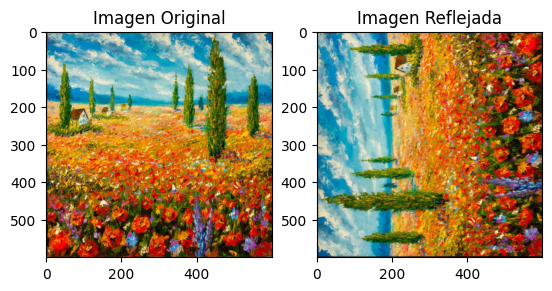

In [37]:
drawing = False
point1 = ()
point2 = ()

def draw_line(event, x, y, flags, param):
    global point1, point2, drawing, image_copy

    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        point1 = (x, y)
        point2 = (x, y)
    
    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            image_copy = image.copy()
            point2 = (x, y)
            cv.line(image_copy, point1, point2, (0, 0, 255), 2)
    
    elif event == cv.EVENT_LBUTTONUP:
        drawing = False
        point2 = (x, y)
        cv.line(image_copy, point1, point2, (0, 0, 255), 2)

def reflect_image(image, point1, point2):
    p1 = np.array(point1, dtype=np.float32)
    p2 = np.array(point2, dtype=np.float32)
    
    delta = p2 - p1
    normal = np.array([-delta[1], delta[0]])
    normal /= np.linalg.norm(normal)
    
    reflection_matrix = np.eye(3)
    reflection_matrix[0, 0] = 1 - 2 * normal[0] * normal[0]
    reflection_matrix[0, 1] = -2 * normal[0] * normal[1]
    reflection_matrix[1, 0] = -2 * normal[0] * normal[1]
    reflection_matrix[1, 1] = 1 - 2 * normal[1] * normal[1]
    
    translation_to_origin = np.eye(3)
    translation_to_origin[0, 2] = -p1[0]
    translation_to_origin[1, 2] = -p1[1]
    
    translation_back = np.eye(3)
    translation_back[0, 2] = p1[0]
    translation_back[1, 2] = p1[1]
    
    transform = translation_back @ reflection_matrix @ translation_to_origin
    
    reflected_image = cv.warpAffine(image, transform[:2], (image.shape[1], image.shape[0]), flags=cv.INTER_LINEAR)
    
    return reflected_image

image = cv.imread('./images/img_cuadro.jpg', cv.IMREAD_COLOR)
image = cv.resize(image, (600, 600))
image_copy = image.copy()

cv.namedWindow("Image")
cv.setMouseCallback("Image", draw_line)

print("Por favor, haga clic y arrastre para definir la línea de reflexión.")

while True:
    cv.imshow("Image", image_copy)
    key = cv.waitKey(1) & 0xFF
    if key == ord('r') and point1 and point2:
        reflected_image = reflect_image(image, point1, point2)
        cv.imshow("Reflected Image", reflected_image)
    elif key == 27:
        break

cv.destroyAllWindows()

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

if 'reflected_image' in locals():
    plt.subplot(1, 2, 2)
    plt.title('Imagen Reflejada')
    plt.imshow(cv.cvtColor(reflected_image, cv.COLOR_BGR2RGB))

plt.show()
